# Need to shift over the clustered signals so that their mean value is at 662 keV
# this amounts to finding their current mean value in the trapezoidal distribution and left or right shifting the distribution over

In [28]:
import h5py
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import norm
from tabulate import tabulate
import os
import scipy.io as sio
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import time
PI = np.pi

In [2]:
def delay_signal(signal, delay=2000, w=500, seed=69):
    np.random.seed(seed)
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w):
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(round(2.5*peaking_time+gap_time, 0))
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)

def get_kv2(v):
    Max_Ind = np.argmax(v)
    step = 10
#     Peak_mu = np.mean(v[Max_Ind:Max_Ind+step])
#     Peak_std = np.std(v[Max_Ind:Max_Ind+step])
    maxmax_roof = np.max(v)
#     mu_floor = np.mean(v[0:500])
#     std_floor = np.std(v[0:500])
    minmax_floor = np.max(v[0:200])
    # now run through the array from 0 up to Max_Ind + 20
    N = []

#     for n in range(len(v[0:Max_Ind+step])):
#         if ((v[n]>minmax_floor*2) and (v[n]<Peak_mu-Peak_std)):
#             N.append(n)
#     return np.array([N[0],N[-1], N[-1]-N[0]])

    for n in range(len(v[0:Max_Ind+step])):
        if ((v[n]>minmax_floor*1.8) and (v[n]<0.98*maxmax_roof)):
            N.append(n)
    return np.array([N[0],N[-1], N[-1]-N[0]])
    #return np.array(N[0])
    
def DAQ_Echo(Time_Stamps):
    echo_index = []
    for n in range(len(times)-1):
        if times[n+1]<times[n]:
            echo_index.append(n)
    return echo_index[0]
    
def Filter_Signals(v_raw):
    v_raw = savgol_filter(v_raw, 51, 2) # maybe play with filtering
    noise = np.mean(v_raw[0:100])
    v = v_raw - noise
    return v

def Filter_Signals_Get_Rise(Data):
    Smooted_data = []
    Rise_Info = []
    for n in range(Data.shape[0]):
        v_raw = savgol_filter(Data[n,:], 51, 2) # maybe play with filtering
        noise = np.mean(v_raw[0:100])
        v = v_raw - noise
        try:
            Rise_Info.append(get_kv2(v))
            Smooted_data.append(v)
        except Exception:
            pass
    return np.array(Smooted_data), np.array(Rise_Info)

# def Filter_Signals_Get_Rise(Data,time_stamps):
#     Smooted_data = []
#     Rise_Info = []
#     TS = DAQ_Echo(Time_Stamps=time_stamps)
#     for n in range(TS):
#         v_raw = savgol_filter(Data[n,:], 51, 2) # maybe play with filtering
#         noise = np.mean(v_raw[0:100])
#         v = v_raw - noise
#         try:
#             Rise_Info.append(get_kv2(v))
#             Smooted_data.append(v)
#         except Exception:
#             pass
#     return np.array(Smooted_data), np.array(Rise_Info)

def Exp_Func(x,A,m):
    return A*np.exp(-m*x)

def Exp_Fit(x,y):
    popt, pcov = curve_fit(Exp_Func,x,y)
    return popt


def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def Lin_Func(x,m,b):
    return m*x+b

def Lin_Fit(x,y):
    popt, pcov = curve_fit(Lin_Func,x,y)
    return popt

def Energy_Func(x,b,a1,a2,a3,a4,a5):
    return b + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5

def Energy_Fit(x,y):
    popt, pcov = curve_fit(Energy_Func,x,y)
    return popt

def Generate_Trap_Amps(Signal_Dirr, file_name, K, GT, Tau):
    os.chdir(Signal_Dirr)
    f_name = file_name
    f = h5py.File(f_name, 'r')
    key1 = 'event_data'
    key2 = 'raw_data'
    branch1 = 'timestamp'
#     times = f[key1][branch1]
#     times = np.array(times)
    Data = f[key2]
    Data = np.array(Data)
    #Signals_Smooth = [Filter_Signals(Data[n,:]) for n in range(Data.shape[0])]
    Signals_Smooth, Rise_Info = Filter_Signals_Get_Rise(Data)
    #Signals_Smooth, Rise_Info = Filter_Signals_Get_Rise(Data,times)
    print('The Smoothing is complete')
    DL = Signals_Smooth.shape[0]
    #Rise_Info = np.array([get_kv2(Signals_Smooth[n]) for n in range(Data.shape[0])])
    k = Rise_Info[:,2] # rise time
    r = Rise_Info[:,1] # end rise
    i = Rise_Info[:,0] # start rise
    mean_k = int(np.mean(k)) # mean rise time
    print('the mean value for k is ',mean_k)
    V = np.array(Signals_Smooth)
    if K == 0:
        K = mean_k
    else:
        K = K
    
    trappy = np.array([s(signal=V[n], start_rise=i[n], tau=Tau, peaking_time=K,gap_time=GT) for n in range(DL)])
    
    Y = []
    for n in range(DL):
        Y.append(np.max(trappy[n]))
    Y = np.array(Y)
    
    return Y

def Get_Hist_Mus(Y,Upperlimit,Del,Source):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    H, binz = np.histogram(Y,bins=2**11)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    stds = []
    if Source == 'Cs137':
        peak, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind = [binz[peak]]
    else:
        peak1, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind1 = binz[peak1]
        x1,x2 = ind1-Del, ind1+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        x = binz[b0:b1] 
        gf = fp[0] + fp[1]*np.exp(-(x - fp[2]) ** 2 / (2 * fp[3] ** 2))
        # plt.show()
        Hnew = np.copy(H)
        change = Hnew[b0:b1] - gf
        Hnew[b0:b1] = change
        peak2 = np.argmax(Hnew[2:-1])
        
        ind = [binz[peak1], binz[peak2]]

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Mus.append(mu)
        stds.append(std)
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1
        
        ax1.hist(Y, bins=2**11)
        ax1.set_title(Source)
        
        ax2.hist(Y, bins=2**11)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(stds)

    
def Get_Hist_Mus_calibrated(Y,Upperlimit,Del,Source,Calb):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    H, binz = np.histogram(Y,bins=2**11)
    Del = Lin_Func(Del,*Calb)
    binz = Lin_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    if Source == 'Cs137':
        peak, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind = [binz[peak]]
    else:
        peak1, _ = find_peaks(H[2:-1], height=np.max(H[2:-1]))
        ind1 = binz[peak1]
        x1,x2 = ind1-Del, ind1+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        x = binz[b0:b1] 
        gf = fp[0] + fp[1]*np.exp(-(x - fp[2]) ** 2 / (2 * fp[3] ** 2))
        # plt.show()
        Hnew = np.copy(H)
        change = Hnew[b0:b1] - gf
        Hnew[b0:b1] = change
        peak2 = np.argmax(Hnew[2:-1])
        
        ind = [binz[peak1], binz[peak2]]

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Mus.append(mu)
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1
        
        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)
        
        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus)
    

def Reduce_Histo(H,binz,Ind,Del):
    x1,x2 = Ind-Del, Ind+Del
    b0 = np.argmin(np.abs(binz - x1))
    b1 = np.argmin(np.abs(binz - x2))
    fp = gauss_fit(binz[b0:b1], H[b0:b1])
#     offset, A, mu, std = test_gauss
#     Res = 2*np.sqrt(2*np.log(2))*100*std/mu
    x = binz[b0:b1] 
    gf = fp[0] + fp[1]*np.exp(-(x - fp[2]) ** 2 / (2 * fp[3] ** 2))
    # plt.show()
    Hnew = np.copy(H)
    #change = Hnew[b0:b1] - gf
    change = Hnew[b0:b1] - Hnew[b0:b1]
    Hnew[b0:b1] = change
    peak = np.argmax(Hnew[2:-1])

    return Hnew, peak




def Get_Hist_Mus_calibrated_V1(Y,Upperlimit,Del,Source,num_peaks):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    stds = []
    ind = []
    ind.append(binz[np.argmax(H[2:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[2:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        if Res<5:
            Mus.append(mu)
            stds.append(std)
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)

        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(stds)


def Get_Hist_Mus_calibrated_V2(Y,Upperlimit,Del,Source,Calb,num_peaks):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
    Del = Lin_Func(Del,*Calb)
    binz = Lin_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    ind = []
    ind.append(binz[np.argmax(H[2:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[2:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        if Res<5:
            Mus.append(mu)
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)

        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus)

def Get_Ballistics(Y,Upperlimit,Del,Source,Calb,num_peaks):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
    Del = Energy_Func(Del,*Calb)
    binz = Energy_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    Resz = []
    ind = []
    ind.append(binz[np.argmax(H[2:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[2:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        Mus.append(mu)
        Resz.append(Res)
        print('The res is ',Res)

        #plt.figure(figsize=(8,6))
        #plotting
        gs = gridspec.GridSpec(2, 2)
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(gs[0, :]) # row 0, span all columns
        ax2 = fig.add_subplot(gs[1, 0]) # row 1, col 0
        ax3 = fig.add_subplot(gs[1, 1]) # row 1, col 1

        #ax1.hist(Y, bins=2**11)
        ax1.hist(binz[:-1], binz, weights=H)
        ax1.set_title(Source)

        #ax2.bar(binz[:-1],H)
        ax2.hist(binz[:-1], binz, weights=H)
        ax2.plot(binz[b0:b1], gauss(binz[b0:b1], *fp),label='Res='+str(round(Res,3))+'%')
        ax2.set_title(Source+' with Gaussian Fit Overlay',fontsize=10)
        ax2.legend()
        ax3.plot(binz[b0:b1], H[b0:b1])
        ax3.plot(binz[b0:b1], gauss(binz[b0:b1], *fp))
        title = "Fit results "+Source+": $\mu$ = %.2f" % (mu)
        ax3.set_title(title,fontsize=10)
        #plt.show()
        fig.tight_layout()
        #fig.show()
    return np.array(Mus), np.array(Resz)


def Create_Calibrated_Spectrums(Y,Calb,Upperlimit):
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    H, binz= np.histogram(Y,bins=2**11)
    binz = Energy_Func(binz,*Calb)
    return H, binz
#     #fig = plt.figure()
#     plt.hist(binz[:-1], binz, weights=H, histtype='step')
#     plt.semilogy()
#     plt.xlabel('[keV]')
#     plt.ylabel('Counts')
#     plt.xlim(1,binz[-1]+100)
#     #plt.show()
#     plt.hold()


# Load the trapezoid amplitudes.

### Assign amplitudes to a list to plot later
### Assign thresholds to a list to display plots correctly and clean up the display. As long as we dont cut into the peak, its fine. Its just for displaying purposes. The Commented upper limits were the thresholds we used when fitting.

In [3]:
# Loading the trapezoids
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab1/DATA/Combined_Data')
Trapezoids = sio.loadmat('Lab1_Trapezoids_Echo.mat')
y_cs137 = Trapezoids['Cs137'].reshape(-1) # upperlimimt is 1.95E+05
y_co57 = Trapezoids['Co57'].reshape(-1) # upperlimimt is 9.0E+04
y_co60 = Trapezoids['Co60'].reshape(-1) # upperlimimt is 1.0E+06
y_Th228 = Trapezoids['Th228'].reshape(-1) # upperlimimt is 0.8E+06

ys = []
ys.append(y_cs137)
ys.append(y_co57)
ys.append(y_co60)
ys.append(y_Th228)
ULS = []
ULS.append(1.95E+05)
ULS.append(9.0E+04)
ULS.append(1.0E+06)
ULS.append(1.8E+06)

# Load the Energy Calibration File Parameters.

In [4]:
os.chdir(r'/Users/curtisberger/PythonPrograms/NE204/Lab1/DATA/Combined_Data')
ECalb = sio.loadmat('ECalb.mat')['Energy_Calb'][0]
print(Energy_Func(0.46,*ECalb))# uncertainty to the gaussian fits and so also the FWHM?

-3.2195840647582052


# Create Calibrated Spectrum

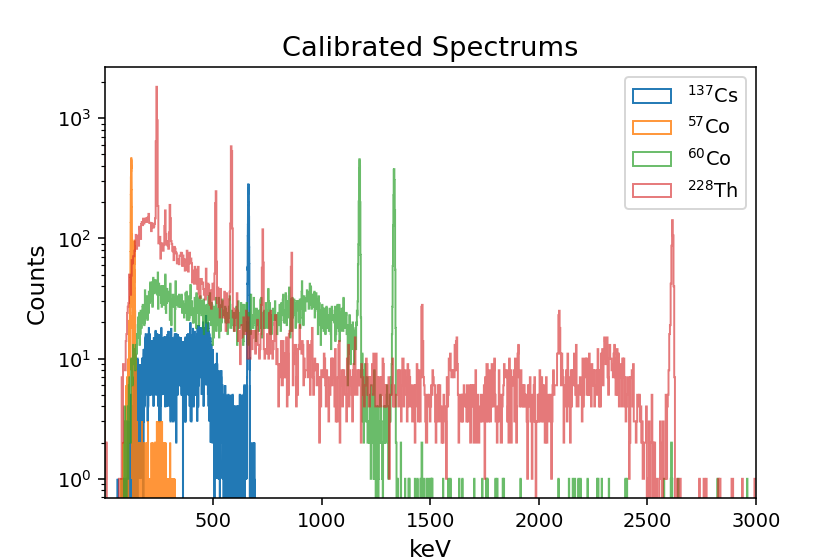

In [5]:
%matplotlib widget

Hs = []
for n in range(len(ys)):
    Hs.append(Create_Calibrated_Spectrums(Y=ys[n],Calb=ECalb,Upperlimit=ULS[n]))

    
labels = ['$^{137}$Cs', '$^{57}$Co', '$^{60}$Co', '$^{228}$Th']
plt.figure(figsize=(6,4),dpi=140)
for i in range(len(ys)):
    plt.hist(Hs[i][1][:-1], Hs[i][1], weights=Hs[i][0], histtype='step',label=labels[i], alpha=0.99/(0.2*i+1))
    #plt.xlim(1,3000)
    plt.legend()
plt.title('Calibrated Spectrums',fontsize=14)
plt.xlim(1,3000)
plt.semilogy()
plt.xlabel('keV',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.show()


(4749,)


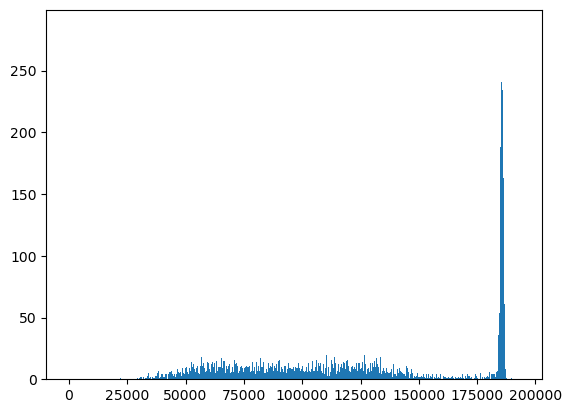

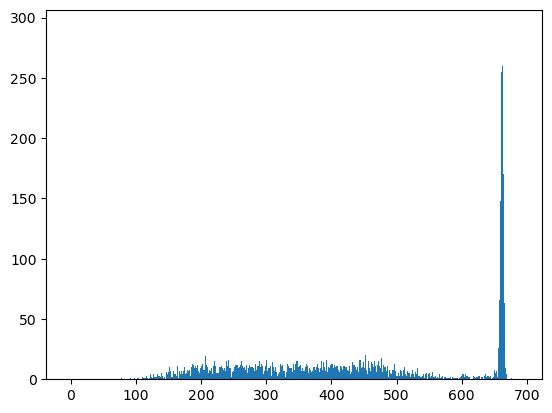

In [6]:
%matplotlib inline

Yc = Energy_Func(y_cs137,*ECalb)
plt.figure()
plt.hist(y_cs137,bins=2**11)

plt.figure()
plt.hist(Yc,bins=2**11)

Is = np.array(np.where((Yc>655) & (Yc<670))).reshape(-1)
print(Is.shape)


In [7]:
#KMeans clustering
from sklearn.cluster import KMeans
def cluster_data(data, n_clust, end, buff=50, quality=True):
    kmeans = KMeans(init='random', n_clusters=n_clust, n_init=10, max_iter=2000, random_state=int(time.time()))
    kmeans.fit(data)
   
    clusts = kmeans.labels_
   
    # Attempting FOM creation
    if quality:
        avg_err = []
        for i in notebook.tqdm(range(len(clusts)), leave=False):
            weight = np.zeros(len(data[i]))
            weight[100:end[i]+buff] = np.ones((end[i]+buff)-100)
            weight = weight/sum(weight)
            val = weight*np.abs((data[i]-kmeans.cluster_centers_[kmeans.labels_[i]])/kmeans.cluster_centers_[kmeans.labels_[i]])
            avg_err.append(np.mean(val))

        return n_clust, np.mean(np.array(avg_err))
    else:
        return n_clust, kmeans

# Load the raw data, smooth, and cluster

In [8]:
Signal_Dirr = r'/Users/curtisberger/PythonPrograms/NE204/Lab1/DATA/Combined_Data'
os.chdir(Signal_Dirr)
f_name = r'Cs137-24in-2.h5'
#f_name = r'EJ-301-Test-Cs137-close-10sec_3.h5'
f = h5py.File(f_name, 'r')
key1 = 'event_data'
key2 = 'raw_data'
branch1 = 'timestamp'
#     times = f[key1][branch1]
#     times = np.array(times)
Data = f[key2]
Data = np.array(Data)
v,_ = Filter_Signals_Get_Rise(Data)


(16145, 62500)
(4749, 62500)
(4749, 3000)


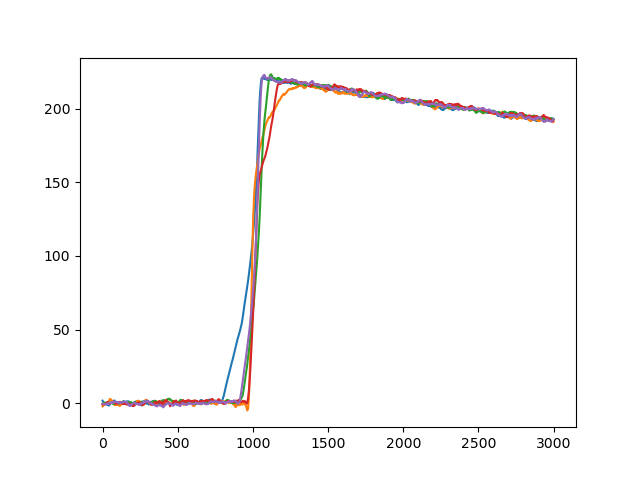

In [9]:
%matplotlib widget
print(v.shape)
V = v[Is]
xtarget = 1300
Threshold = 0.20*xtarget

def Filter_PileUp(v):
    v_ = []
    xtarget = 1300
    Threshold = 0.20*xtarget
    for i in range(v.shape[0]):
        maxI = np.argmax(v[i])
        modv = np.gradient(v[i,2000:])
        Maxmodv = np.max(modv)
        #print(Maxmodv,np.mean(modv))
        if ((maxI < xtarget+Threshold) & (maxI>xtarget-Threshold) & (Maxmodv < 0.5)):
            v_.append(v[i])
    return np.array(v_)
#newV = Filter_PileUp(V)
newV = V[:,0:3000]
print(V.shape)
print(newV.shape)
plt.figure()
for i in range(5):
    plt.plot(newV[i,:])
#start exponential fit at x=1800    
#N, kMs = cluster_data(v[Is], n_clust=50, end=1, buff=50, quality=False)

## Evidence of pile up/ charge trapping. I dont think we want to cluster on the bad pulses but we have filtered them.

In [11]:
Ns = []
kM_list = []
for n in range(99):
    N, kMs = cluster_data(newV, n_clust=n+1, end=1, buff=50, quality=False)
    Ns.append(Ns)
    kM_list.append(kMs)
    print(n)
# print(N)
# print(kMs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [16]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` observations (rows) at random from data
 |      for the i

Text(0, 0.5, 'inertia')

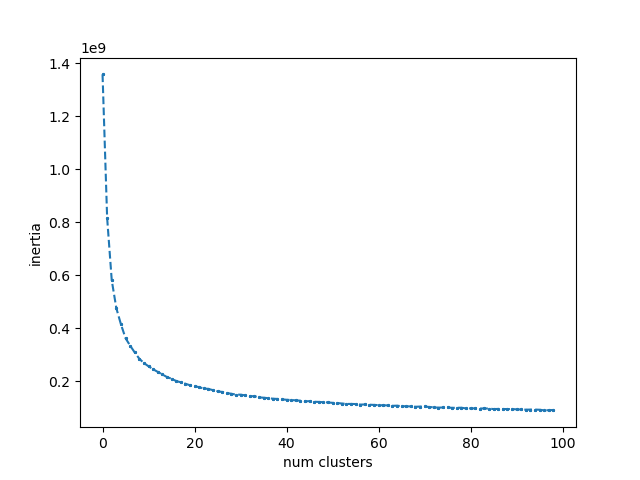

In [27]:
inerts = np.array([kM_list[i].inertia_ for i in range(len(kM_list))])
plt.figure()
plt.plot(inerts,'--*',markersize=2)
plt.xlabel('num clusters')
plt.ylabel('inertia')

264764714.598737
2500
[9 7 8 ... 6 5 4]
(4749,)


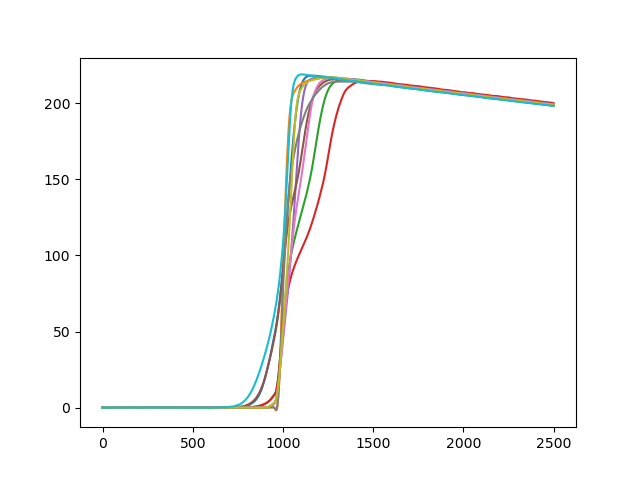

In [35]:
print(kMs.inertia_)
print(kMs.n_features_in_)
print(kMs.labels_) # these labels assign which pulse goes into which mean-vlaue pulse. It is these mean value pulses
# we ought to optimize fro trabezoidal filteirng
Centroids = kMs.cluster_centers_ 
print(kMs.labels_.shape)
Labls = kMs.labels_
%matplotlib widget
plt.figure()
for i in range(Centroids.shape[0]):
    plt.plot(Centroids[i])

In [36]:
import pandas as pd
import numpy.ma as ma
#def Group_Signals_By_Label(v,Labls):
    

In [37]:
df = pd.DataFrame(newV)
df['ClusterId']=Labls
print(df)
DF = df.sort_values(by = 'ClusterId')
print(DF)

             0         1         2         3         4         5         6  \
0     1.654584  1.471560  1.295467  1.126305  0.964074  0.808775  0.660406   
1    -2.236729 -2.145709 -2.055146 -1.965040 -1.875391 -1.786200 -1.697465   
2    -0.458418 -0.386102 -0.317000 -0.251111 -0.188437 -0.128976 -0.072730   
3    -0.944746 -0.923142 -0.900836 -0.877827 -0.854115 -0.829700 -0.804583   
4    -0.320928 -0.372464 -0.421283 -0.467386 -0.510772 -0.551441 -0.589393   
...        ...       ...       ...       ...       ...       ...       ...   
4744  1.762325  1.664725  1.569667  1.477152  1.387180  1.299752  1.214867   
4745  0.966360  0.925011  0.885416  0.847575  0.811489  0.777157  0.744579   
4746  1.943808  1.838705  1.737233  1.639395  1.545188  1.454614  1.367673   
4747  2.529202  2.349050  2.173085  2.001308  1.833719  1.670317  1.511103   
4748 -0.557869 -0.459520 -0.365699 -0.276406 -0.191640 -0.111402 -0.035691   

             7         8         9  ...        2491        2492

(618, 2500)


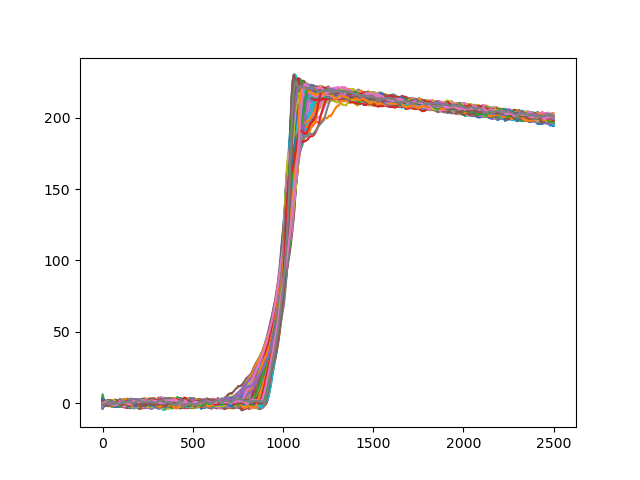

In [42]:
test = DF.where(DF['ClusterId']==0)
test = np.array(test)
test = test[:,0:-1]
test = test[~np.isnan(test)].reshape(-1,newV.shape[1])
print(test.shape)
#print(np.array(df.loc[3,:]).shape)

plt.figure()
for i in range(test.shape[0]):
    plt.plot(test[i])

## Make an array from [0:nclusters:1]

In [57]:
Clusters = np.arange(0,10,1)

In [14]:
TC = 0
C0 = []
x = df['ClusterId'][1]
for n in range(len(df['ClusterId'][:])):
    if df['ClusterId'][n]==TC:
        C0.append(np.array(df.loc[n,:]))
C0 = np.array(C0)
print(C0.shape)

(350, 62501)


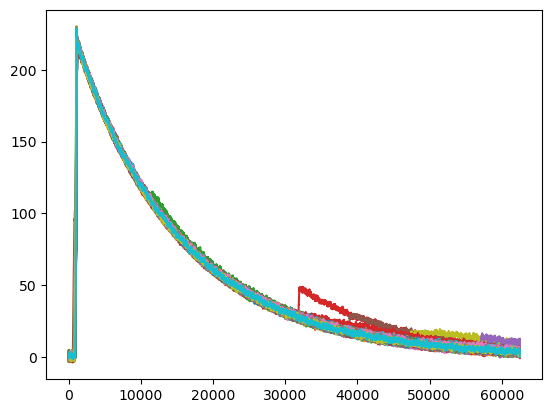

In [15]:
plt.figure()
for i in range(C0.shape[0]):
    plt.plot(C0[i])

# Define the function that will be used to calculate the resolution for the (hopefully optimized) trapezoidal histogram distribution.

In [58]:
def Generate_K_Means_Traps(v, K, GT, Tau):
    _, Rise_Info = Filter_Signals_Get_Rise(v)
    #Signals_Smooth, Rise_Info = Filter_Signals_Get_Rise(Data,times)
    print('The Smoothing is complete')
    DL = v.shape[0]
    #Rise_Info = np.array([get_kv2(Signals_Smooth[n]) for n in range(Data.shape[0])])
    k = Rise_Info[:,2] # rise time
    r = Rise_Info[:,1] # end rise
    i = Rise_Info[:,0] # start rise
    mean_k = int(np.mean(k)) # mean rise time
#     print('the mean value for k is ',mean_k)
#     print(r)
    if K == 0:
        K = mean_k
    else:
        K = K
    
    trappy = np.array([s(signal=v[n], start_rise=i[n], tau=Tau, peaking_time=K,gap_time=GT) for n in range(DL)])
    
    Yt = []
    for n in range(DL):
        Yt.append(np.max(trappy[n]))
    Yt = np.array(Yt)
    
    return Yt

def Get_Hist_Mus_calibrated_VF(Y,Upperlimit,Del,Source,Calb,num_peaks, v, K, GT, Tau):
    Y = Generate_K_Means_Traps(v, K, GT, Tau)
    Cond1 = Y>Upperlimit
    Y[Cond1] = 0
    # Create 2x2 sub plots
    if Source == 'Th228':
        Cond2 = Y<6.0E+04
        Y[Cond2] = 0
    
    H, binz = np.histogram(Y,bins=2**11)
    Del = Energy_Func(Del,*Calb)
    binz = Energy_Func(binz,*Calb)
#     peaks, _ = find_peaks(H[2:-1], height=np.argmax(H[2:-1]))
#     bin_peaks = np.sort(binz[peaks])
    Mus = []
    Resz = []
    ind = []
    ind.append(binz[np.argmax(H[10:-1])])
    H_mod = np.copy(H)
    for i in range(num_peaks-1):
        Max_Ind = np.argmax(H_mod[10:-1])
        Max_Ind = binz[Max_Ind]
        H_mod, Peak = Reduce_Histo(H=H_mod, binz=binz, Ind=Max_Ind, Del=Del)
        ind.append(binz[Peak])

    for n in range(len(ind)):
        x1,x2 = ind[n]-Del, ind[n]+Del
        b0 = np.argmin(np.abs(binz - x1))
        b1 = np.argmin(np.abs(binz - x2))
        fp = gauss_fit(binz[b0:b1], H[b0:b1])
        offset, A, mu, std = fp
        Res = 2*np.sqrt(2*np.log(2))*100*std/mu
        Resz.append(Res)
        if Res<5:
            Mus.append(mu)
        print('The res is ',Res)
    return np.array(Mus), np.array(Resz)


In [59]:
Gaps = np.arange(300,810,10)
Ks = np.arange(300,810,10)
inds = np.ones((len(Ks)**2,2))
counter = 0
Df = pd.DataFrame(inds, columns=['Gaps', 'Ks'])
for i in range(len(Gaps)):
    for j in range(len(Ks)):
        Df['Gaps'][counter]=Gaps[i]
        Df['Ks'][counter]=Ks[j]
        counter+=1
        if counter == len(Ks)**2:
            break

# We will need two loops. One will iterate through all of the gap and k values. The outer loop will iterate through each clustered group. At the end of the day, each clustered group will have a number of calculated resolutions that depend on the k and gap times. As such, it makes sense to create ncluster different dataframes. They need to be de-coupled since the pixel-to-pixel-resolution of each frame might change depending on whether we can sucessfully calculate a resolution for each cluster at specific (k,gap) valued pairs.

In [ ]:
import tqdm.notebook as tq
os.chdir(r'C:\Users\Curtis\Documents\jup\data\ClusterV4')
N = np.arange(0,len(Ks)**2+1,1)
print(N)
C = 0
d = 0
for i in Clusters:
    Success_mask = []
    Resolutions = []
    #print(i)
    del C
    C = DF.where(DF['ClusterId']==i)
    C = np.array(C)
    C = C[:,0:-1]
    C = C[~np.isnan(C)].reshape(-1,newV.shape[1])
    for n in tq.tqdm(N, leave=False):
    #for n in N:
        try:
            _,stdres = Get_Hist_Mus_calibrated_VF(Y=0,Upperlimit=1.95E+05,Del=8000,Source='Cs137',
                                                  Calb=ECalb,num_peaks=1, v=C, K=int(Df['Ks'][n]), GT=int(Df['Gaps'][n]), 
                                                  Tau=12617)
            #print('the res is ',stdres)
            Success_mask.append(n)
            Resolutions.append(stdres)
        except Exception:
            #print('bad')
            pass
        #print(n)
        
    Resolutions = np.array(Resolutions).reshape(-1)
    Success_mask = np.array(Success_mask).reshape(-1)
    DDF={}
    DDF['Success Mask']=Success_mask
    DDF['Resolutions']=Resolutions
    sio.savemat('Cluster'+str(i)+'.mat',DDF)